In [11]:
import pandas as pd

data = pd.read_csv("/Users/nguyendinhhuy/Desktop/Ny Project/Project 4/Project 3/w15_cluster.csv")
data['interval'] = data['Timesteps']

total_samples = len(data)
train_percentage = 0.9
valid_percentage = 0.065
test_percentage = 0.035

train_size = int(total_samples * train_percentage)
valid_size = int(total_samples * valid_percentage)
test_size = total_samples - train_size - valid_size

train_size = train_size - (train_size % 96)
valid_size = valid_size - (valid_size % 96)
test_size = total_samples - train_size - valid_size

train_size = total_samples - valid_size - test_size

train_data = data.iloc[:train_size]
valid_data = data.iloc[train_size:train_size + valid_size]
test_data = data.iloc[train_size + valid_size:train_size + valid_size + test_size]

train_data.to_csv("train_shalun15_c.csv", index=False)
valid_data.to_csv("valid_shalun15_c.csv", index=False)
test_data.to_csv("test_shalun15_c.csv", index=False)

print(f"Total samples: {total_samples}")
print(f"Train size (divisible by 96): {train_size}")
print(f"Valid size (divisible by 96): {valid_size}")
print(f"Test size (divisible by 96): {test_size}")


Total samples: 16896
Train size (divisible by 96): 15168
Valid size (divisible by 96): 1056
Test size (divisible by 96): 672


# One-step ahead

In [12]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

train_data = pd.read_csv('train_shalun15_c.csv')
val_data = pd.read_csv('valid_shalun15_c.csv')
test_data = pd.read_csv('test_shalun15_c.csv')

encoder_features = [ 'clearsky_ghi', 'uv_index', 'D_lw1', 'D_lw2', 'D_lw3', 'D_lw4', 
                    'D_lw5', 'D_lw6', 'D_lw7', 'zenith', 'D_15min',
                    'Timesteps','day','month','hour','minute']
decoder_features = ['clearsky_ghi', 'uv_index', 'D_lw1', 'D_lw2', 'D_lw3', 'D_lw4', 
                    'D_lw5', 'D_lw6', 'D_lw7', 'zenith', 'D_15min',
                    'Timesteps','day','month','hour','minute']  
target_column = ['kW']  #
def create_one_step_data(data, enc_features, dec_features, target, time_steps=1):
    X_enc, X_dec, y = [], [], []
    for i in range(time_steps, len(data)):
        X_enc.append(data[enc_features].iloc[i - time_steps:i].values.flatten())
        
        X_dec.append(data[dec_features].iloc[i - time_steps:i].values.flatten())
        
        y.append(data[target].iloc[i].values)
    return np.array(X_enc), np.array(X_dec), np.array(y)

time_steps = 1  
X_enc_train, X_dec_train, y_train = create_one_step_data(train_data, encoder_features, decoder_features, target_column, time_steps)
X_enc_val, X_dec_val, y_val = create_one_step_data(val_data, encoder_features, decoder_features, target_column, time_steps)
X_enc_test, X_dec_test, y_test = create_one_step_data(test_data, encoder_features, decoder_features, target_column, time_steps)

scaler_enc = StandardScaler()
scaler_dec = StandardScaler()
scaler_y = StandardScaler()

X_enc_train = scaler_enc.fit_transform(X_enc_train)
X_dec_train = scaler_dec.fit_transform(X_dec_train)
y_train = scaler_y.fit_transform(y_train)

X_enc_val = scaler_enc.transform(X_enc_val)
X_dec_val = scaler_dec.transform(X_dec_val)
y_val = scaler_y.transform(y_val)

X_enc_test = scaler_enc.transform(X_enc_test)
X_dec_test = scaler_dec.transform(X_dec_test)
y_test = scaler_y.transform(y_test)

X_enc_train = torch.tensor(X_enc_train, dtype=torch.float32)
X_dec_train = torch.tensor(X_dec_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_enc_val = torch.tensor(X_enc_val, dtype=torch.float32)
X_dec_val = torch.tensor(X_dec_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_enc_test = torch.tensor(X_enc_test, dtype=torch.float32)
X_dec_test = torch.tensor(X_dec_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_enc_train, X_dec_train, y_train)
val_dataset = TensorDataset(X_enc_val, X_dec_val, y_val)
test_dataset = TensorDataset(X_enc_test, X_dec_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for X_enc_batch, X_dec_batch, y_batch in train_loader:
    print(f"X_enc_batch shape: {X_enc_batch.shape}")  
    print(f"X_dec_batch shape: {X_dec_batch.shape}")  
    print(f"y_batch shape: {y_batch.shape}")  
    break


X_enc_batch shape: torch.Size([32, 16])
X_dec_batch shape: torch.Size([32, 16])
y_batch shape: torch.Size([32, 1])


In [13]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        
        self.decoder = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)
        )
        self.decoderLinear = nn.Sequential(
            nn.Linear(len(decoder_features), d_model),  
            nn.BatchNorm1d(d_model)
        )

    def forward(self, src, src_dec):
        encoder_output = self.encoder(self.encoderLinear(src))
        decoder_output = self.decoder(encoder_output, self.decoderLinear(src_dec))
        return decoder_output



In [14]:
import torch.optim as optim

model = MultiDeT()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.007, weight_decay=0.01)  

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_dec, y in train_loader:  
            optimizer.zero_grad()

            output = model(X_enc, X_dec)

            output = output.view(-1)

            loss = criterion(output, y.view(-1))  
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_dec, y in val_loader:  # Use both encoder and decoder inputs
                # Model forward pass
                output = model(X_enc, X_dec)

                # Reshape the output
                output = output.view(-1)

                # Compute validation loss
                loss = criterion(output, y.view(-1))
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
            best_model_wts = model.state_dict()  # Save the best model weights
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_wts)  # Load the best model weights
            break

    return train_losses, val_losses


# Train the model
train_losses, val_losses = train_model_with_early_stopping(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=10
)


/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Training Loss: 0.1319
Epoch 1/10, Validation Loss: 0.1109
Epoch 2/10, Training Loss: 0.1085
Epoch 2/10, Validation Loss: 0.0808
Epoch 3/10, Training Loss: 0.1079
Epoch 3/10, Validation Loss: 0.0829
Epoch 4/10, Training Loss: 0.1075
Epoch 4/10, Validation Loss: 0.0680
Epoch 5/10, Training Loss: 0.1020
Epoch 5/10, Validation Loss: 0.0787
Epoch 6/10, Training Loss: 0.1059
Epoch 6/10, Validation Loss: 0.0843
Epoch 7/10, Training Loss: 0.1023
Epoch 7/10, Validation Loss: 0.0815
Epoch 8/10, Training Loss: 0.1012
Epoch 8/10, Validation Loss: 0.0802
Epoch 9/10, Training Loss: 0.1022
Epoch 9/10, Validation Loss: 0.0886
Epoch 10/10, Training Loss: 0.0986
Epoch 10/10, Validation Loss: 0.1211


In [15]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from torch.utils.data import DataLoader, TensorDataset
# import matplotlib.pyplot as plt

# # Define Encoder
# class Encoder(nn.Module):
#     def __init__(self, num_layers, d_model, dropout=0.1):
#         super(Encoder, self).__init__()
#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
#         self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.norm = nn.LayerNorm(d_model)

#     def forward(self, x):
#         x = self.encoder(x)
#         return self.norm(x)

# # Define Decoder
# class Decoder(nn.Module):
#     def __init__(self, num_layers, d_model, dropout=0.1):
#         super(Decoder, self).__init__()
#         decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
#         self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
#         self.norm = nn.LayerNorm(d_model)
#         self.output_layer = nn.Linear(d_model, 1)

#     def forward(self, memory, x):
#         x = self.decoder(x, memory)
#         x = self.norm(x)
#         x = self.output_layer(x)
#         return x

# # Define MultiDeT model
# class MultiDeT(nn.Module):
#     def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.1):
#         super(MultiDeT, self).__init__()
#         self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
#         self.decoder = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
#         self.encoderLinear = nn.Sequential(
#             nn.Linear(len(encoder_features), d_model),
#             nn.BatchNorm1d(d_model)
#         )
#         self.decoderLinear = nn.Sequential(
#             nn.Linear(len(decoder_features), d_model),
#             nn.BatchNorm1d(d_model)
#         )

#     def forward(self, src, src_dec):
#         encoder_output = self.encoder(self.encoderLinear(src))
#         decoder_output = self.decoder(encoder_output, self.decoderLinear(src_dec))
#         return decoder_output

# # Training function
# def train_model_until_mape(model, train_loader, val_loader, criterion, optimizer, num_epochs=1000, target_mape=7):
#     train_losses = []
#     val_losses = []
#     best_val_loss = float('inf')
#     best_val_mape = float('inf')
#     best_model_wts = None

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for X_enc, X_dec, y in train_loader:
#             optimizer.zero_grad()
#             output = model(X_enc, X_dec)
#             output = output.view(-1)
#             loss = criterion(output, y.view(-1))
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * X_enc.size(0)

#         epoch_loss = running_loss / len(train_loader.dataset)
#         train_losses.append(epoch_loss)
#         print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         val_true_values = []
#         val_predicted_values = []
#         with torch.no_grad():
#             for X_enc, X_dec, y in val_loader:
#                 output = model(X_enc, X_dec)
#                 output = output.view(-1)
#                 loss = criterion(output, y.view(-1))
#                 val_loss += loss.item() * X_enc.size(0)
#                 val_true_values.extend(y.cpu().numpy())
#                 val_predicted_values.extend(output.cpu().numpy())

#         val_loss = val_loss / len(val_loader.dataset)
#         val_losses.append(val_loss)
#         print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

#         # Calculate MAPE
#         val_true_values = np.array(val_true_values)
#         val_predicted_values = np.array(val_predicted_values)
#         val_true_values = scaler_y.inverse_transform(val_true_values.reshape(-1, 1)).flatten()
#         val_predicted_values = scaler_y.inverse_transform(val_predicted_values.reshape(-1, 1)).flatten()
#         val_mape = np.mean(np.abs((val_true_values - val_predicted_values) / val_true_values)) * 100
#         print(f'Epoch {epoch+1}/{num_epochs}, Validation MAPE: {val_mape:.2f}%')

#         # Save the model if MAPE improves
#         if val_mape < best_val_mape:
#             best_val_mape = val_mape
#             best_val_loss = val_loss
#             best_model_wts = model.state_dict()

#         # Stop training if MAPE is below the target
#         if val_mape < target_mape:
#             print(f"Training stopped as Validation MAPE reached below {target_mape}%.")
#             break

#     # Load the best model weights
#     if best_model_wts:
#         model.load_state_dict(best_model_wts)

#     return train_losses, val_losses, best_val_mape

# # Initialize model, optimizer, and criterion
# model = MultiDeT()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.1)

# # Train the model
# train_losses, val_losses, best_mape = train_model_until_mape(
#     model, train_loader, val_loader, criterion, optimizer, num_epochs=1000, target_mape=7.5
# )

# # Evaluation function
# def evaluate_model(model, test_loader, criterion, scaler_y):
#     model.eval()
#     test_loss = 0.0
#     true_values = []
#     predicted_values = []

#     with torch.no_grad():
#         for X_enc, X_dec, y in test_loader:
#             output = model(X_enc, X_dec)
#             output = output.view(-1)
#             loss = criterion(output, y.view(-1))
#             test_loss += loss.item() * X_enc.size(0)
#             true_values.extend(y.cpu().numpy())
#             predicted_values.extend(output.cpu().numpy())

#     test_loss = test_loss / len(test_loader.dataset)
#     print(f'Test Loss: {test_loss:.4f}')

#     true_values = np.array(true_values)
#     predicted_values = np.array(predicted_values)

#     true_values = scaler_y.inverse_transform(true_values.reshape(-1, 1)).flatten()
#     predicted_values = scaler_y.inverse_transform(predicted_values.reshape(-1, 1)).flatten()

#     mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
#     print(f'MAPE: {mape:.2f}%')

#     return true_values, predicted_values, mape

# # Evaluate the model
# true_values, predicted_values, mape = evaluate_model(model, test_loader, criterion, scaler_y)

# # Plot results
# plt.figure(figsize=(25, 6))
# plt.plot(true_values, label='True Values', color='blue')
# plt.plot(predicted_values, label='Predicted Values', color='orange', linestyle='--')
# plt.yticks(fontsize=16)
# plt.xticks(fontsize=16)
# plt.xlabel('Time (Intervals)', fontsize=20)
# plt.ylabel('kW (Power)', fontsize=20)
# plt.legend(fontsize=18)
# plt.title(f'MAPE: {mape:.2f}%', fontsize=20)
# plt.grid(alpha=0.5)
# plt.show()

Test Loss: 0.0758
MAPE: 10.76%


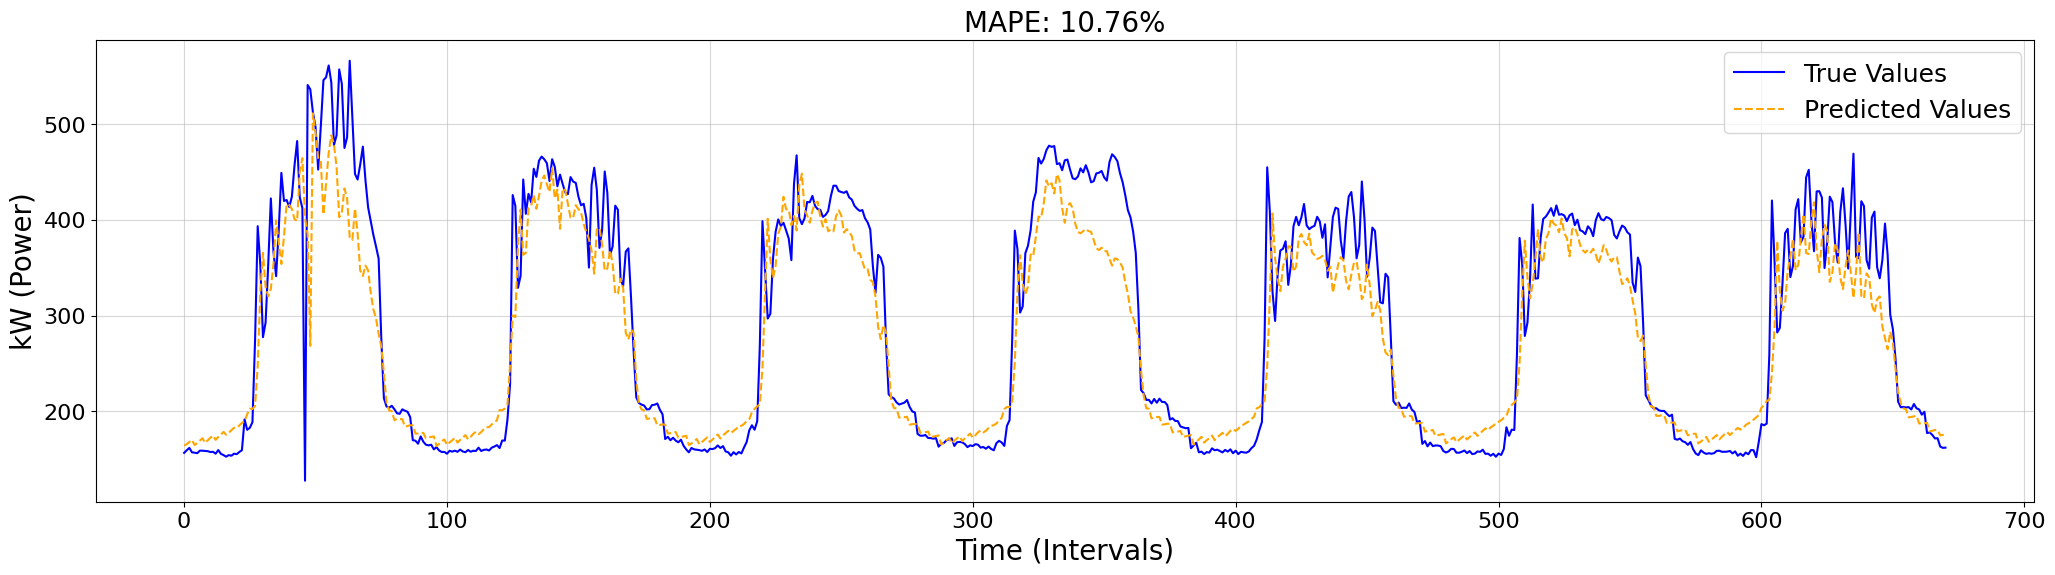

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values = []
    predicted_values = []

    with torch.no_grad():
        for X_enc, X_dec, y in test_loader:  
            output = model(X_enc, X_dec)  

            output = output.view(-1)

            loss = criterion(output, y.view(-1))  
            test_loss += loss.item() * X_enc.size(0)

            true_values.extend(y.cpu().numpy())
            predicted_values.extend(output.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    true_values = np.array(true_values)
    predicted_values = np.array(predicted_values)

    true_values = scaler_y.inverse_transform(true_values.reshape(-1, 1)).flatten()
    predicted_values = scaler_y.inverse_transform(predicted_values.reshape(-1, 1)).flatten()

    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    print(f'MAPE: {mape:.2f}%')

    return true_values, predicted_values, mape

true_values, predicted_values, mape = evaluate_model(model, test_loader, criterion, scaler_y)

plt.figure(figsize=(25, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='orange', linestyle='--')
plt.yticks(fontsize=16)  
plt.xticks(fontsize=16)  
plt.xlabel('Time (Intervals)', fontsize=20)
plt.ylabel('kW (Power)', fontsize=20)
plt.legend(fontsize=18)
plt.title(f'MAPE: {mape:.2f}%', fontsize=20)
plt.grid(alpha=0.5)  
plt.show()


# One-day ahead

In [17]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

train_data = pd.read_csv('train_shalun15_c.csv')
val_data = pd.read_csv('valid_shalun15_c.csv')
test_data = pd.read_csv('test_shalun15_c.csv')

encoder_features = [ 'clearsky_ghi', 'uv_index', 'D_lw1', 'D_lw2', 'D_lw3', 'D_lw4', 
                    'D_lw5', 'D_lw6', 'D_lw7', 'zenith', 
                    'Timesteps','day','month','hour','minute']
decoder_features = ['clearsky_ghi', 'uv_index', 'D_lw1', 'D_lw2', 'D_lw3', 'D_lw4', 
                    'D_lw5', 'D_lw6', 'D_lw7', 'zenith',
                    'Timesteps','day','month','hour','minute']  

target_column = 'kW'

# Create scalers
scaler_encoder = StandardScaler()
scaler_decoder = StandardScaler()
scaler_target = StandardScaler()

# Encoder feature scaling
X_encoder_train = scaler_encoder.fit_transform(train_data[encoder_features])
X_encoder_val = scaler_encoder.transform(val_data[encoder_features])
X_encoder_test = scaler_encoder.transform(test_data[encoder_features])

# Decoder feature scaling
X_decoder_train = scaler_decoder.fit_transform(train_data[decoder_features])
X_decoder_val = scaler_decoder.transform(val_data[decoder_features])
X_decoder_test = scaler_decoder.transform(test_data[decoder_features])

# Target scaling
y_train = scaler_target.fit_transform(train_data[[target_column]])
y_val = scaler_target.transform(val_data[[target_column]])
y_test = scaler_target.transform(test_data[[target_column]])


# Convert to PyTorch tensors
X_encoder_train = torch.tensor(X_encoder_train, dtype=torch.float32)
X_decoder_train = torch.tensor(X_decoder_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_encoder_val = torch.tensor(X_encoder_val, dtype=torch.float32)
X_decoder_val = torch.tensor(X_decoder_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_encoder_test = torch.tensor(X_encoder_test, dtype=torch.float32)
X_decoder_test = torch.tensor(X_decoder_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_encoder_train, X_decoder_train, y_train)
val_dataset = TensorDataset(X_encoder_val, X_decoder_val, y_val)
test_dataset = TensorDataset(X_encoder_test, X_decoder_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for X_enc_batch, X_dec_batch, y_batch in train_loader:
    print(f"X_enc_batch shape: {X_enc_batch.shape}")
    print(f"X_dec_batch shape: {X_dec_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    break


X_enc_batch shape: torch.Size([32, 15])
X_dec_batch shape: torch.Size([32, 15])
y_batch shape: torch.Size([32, 1])


In [18]:
print(train_data.columns)
print(val_data.columns)
print(test_data.columns)


Index(['Unnamed: 0.1', 'Unnamed: 0', 'Time', 'kW', 'temperature',
       'rain_probability', 'feel_temperature', 'humidity', 'uv_index',
       'cloud_cover', 'rain_amount', 'air_temp', 'albedo', 'azimuth',
       'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti',
       'cloud_opacity', 'cloud_opacity10', 'cloud_opacity90', 'dewpoint_temp',
       'dni', 'dhi10', 'dhi90', 'ghi', 'ghi10', 'ghi90', 'precipitable_water',
       'precipitation_rate', 'relative_humidity', 'wind_direction_100m',
       'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith',
       'Date', 'Weekday', 'Max kW', 'Day Type', 'year', 'month', 'day', 'hour',
       'minute', 'D_lw1', 'D_lw2', 'D_lw3', 'D_lw4', 'D_lw5', 'D_lw6', 'D_lw7',
       'D_15min', 'Timesteps', 'date', 'Index', 'cluster', 'interval'],
      dtype='object')
Index(['Unnamed: 0.1', 'Unnamed: 0', 'Time', 'kW', 'temperature',
       'rain_probability', 'feel_temperature', 'humidity', 'uv_index',
       'cloud_cover', 'r

In [19]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        
        self.decoder = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)
        )
        self.decoderLinear = nn.Sequential(
            nn.Linear(len(decoder_features), d_model),  
            nn.BatchNorm1d(d_model)
        )

    def forward(self, src, src_dec):
        encoder_output = self.encoder(self.encoderLinear(src))
        decoder_output = self.decoder(encoder_output, self.decoderLinear(src_dec))
        return decoder_output



0.009/0.001

In [24]:
import torch.optim as optim

# Khởi tạo mô hình với các đặc trưng cụ thể
model = MultiDeT(
)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.009, weight_decay=0.001)  

import torch

def train_model_until_mape_threshold(model, train_loader, val_loader, criterion, optimizer, num_epochs=2000, test_loader=None, scaler_y=None, mape_threshold=8, model_save_path="best_model.pth"):
    train_losses = []
    val_losses = []

    best_model_wts = None  # Biến lưu trạng thái mô hình tốt nhất

    for epoch in range(num_epochs):
        # Huấn luyện
        model.train()
        running_loss = 0.0
        for X_enc, X_dec, y in train_loader:
            optimizer.zero_grad()

            output = model(X_enc, X_dec)
            output = output.view(-1)

            loss = criterion(output, y.view(-1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Tính toán Validation Loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_dec, y in val_loader:
                output = model(X_enc, X_dec)
                output = output.view(-1)

                loss = criterion(output, y.view(-1))
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        # Đánh giá MAPE
        if test_loader and scaler_y:
            _, _, mape = evaluate_model(model, test_loader, criterion, scaler_y)
            print(f'Epoch {epoch+1}/{num_epochs}, MAPE: {mape:.2f}%')

            # Dừng nếu MAPE < ngưỡng
            if mape < mape_threshold:
                print(f"MAPE threshold reached: {mape:.2f}%. Stopping training and saving model.")
                # Lưu trạng thái mô hình
                torch.save(model.state_dict(), model_save_path)
                print(f"Model saved to {model_save_path}")
                break

    return train_losses, val_losses






train_losses, val_losses = train_model_until_mape_threshold(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=2000, test_loader=test_loader, scaler_y=scaler_y, mape_threshold=6.5
)



/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/2000, Training Loss: 0.1618
Epoch 1/2000, Validation Loss: 0.0937
Test Loss: 0.0599
MAPE: 8.70%
Epoch 1/2000, MAPE: 8.70%
Epoch 2/2000, Training Loss: 0.1260
Epoch 2/2000, Validation Loss: 0.0631
Test Loss: 0.0748
MAPE: 10.18%
Epoch 2/2000, MAPE: 10.18%
Epoch 3/2000, Training Loss: 0.1216
Epoch 3/2000, Validation Loss: 0.0674
Test Loss: 0.0587
MAPE: 9.12%
Epoch 3/2000, MAPE: 9.12%
Epoch 4/2000, Training Loss: 0.1162
Epoch 4/2000, Validation Loss: 0.0701
Test Loss: 0.0470
MAPE: 8.44%
Epoch 4/2000, MAPE: 8.44%
Epoch 5/2000, Training Loss: 0.1134
Epoch 5/2000, Validation Loss: 0.0649
Test Loss: 0.0598
MAPE: 11.94%
Epoch 5/2000, MAPE: 11.94%
Epoch 6/2000, Training Loss: 0.1135
Epoch 6/2000, Validation Loss: 0.0639
Test Loss: 0.1094
MAPE: 17.40%
Epoch 6/2000, MAPE: 17.40%
Epoch 7/2000, Training Loss: 0.1092
Epoch 7/2000, Validation Loss: 0.0579
Test Loss: 0.0726
MAPE: 10.82%
Epoch 7/2000, MAPE: 10.82%
Epoch 8/2000, Training Loss: 0.1109
Epoch 8/2000, Validation Loss: 0.0902
Test Los

In [25]:
# Tải trọng số từ file
model.load_state_dict(torch.load("best_model.pth"))

# Đặt mô hình ở chế độ đánh giá
model.eval()


/var/folders/cm/nfg3lzjx1yb8gh0lpqtj20zc0000gn/T/ipykernel_7158/2229119950.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.p

MultiDeT(
  (encoder): Encoder(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=2048, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Decoder(
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
      

In [27]:
model.eval()  # Đặt chế độ đánh giá

true_values = []
predicted_values = []

with torch.no_grad():
    for X_enc, X_dec, y in test_loader:
        # Dự đoán
        outputs = model(X_enc, X_dec).view(-1)

        # Lưu kết quả
        true_values.extend(y.cpu().numpy())
        predicted_values.extend(outputs.cpu().numpy())

# Chuyển kết quả về thang đo ban đầu (ngược chuẩn hóa)
true_values = scaler_target.inverse_transform(np.array(true_values).reshape(-1, 1)).flatten()
predicted_values = scaler_target.inverse_transform(np.array(predicted_values).reshape(-1, 1)).flatten()

# Tính MAPE
mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
print(f"Test MAPE: {mape:.2f}%")


Test MAPE: 6.58%


Test Loss: 0.0410
MAPE: 6.58%


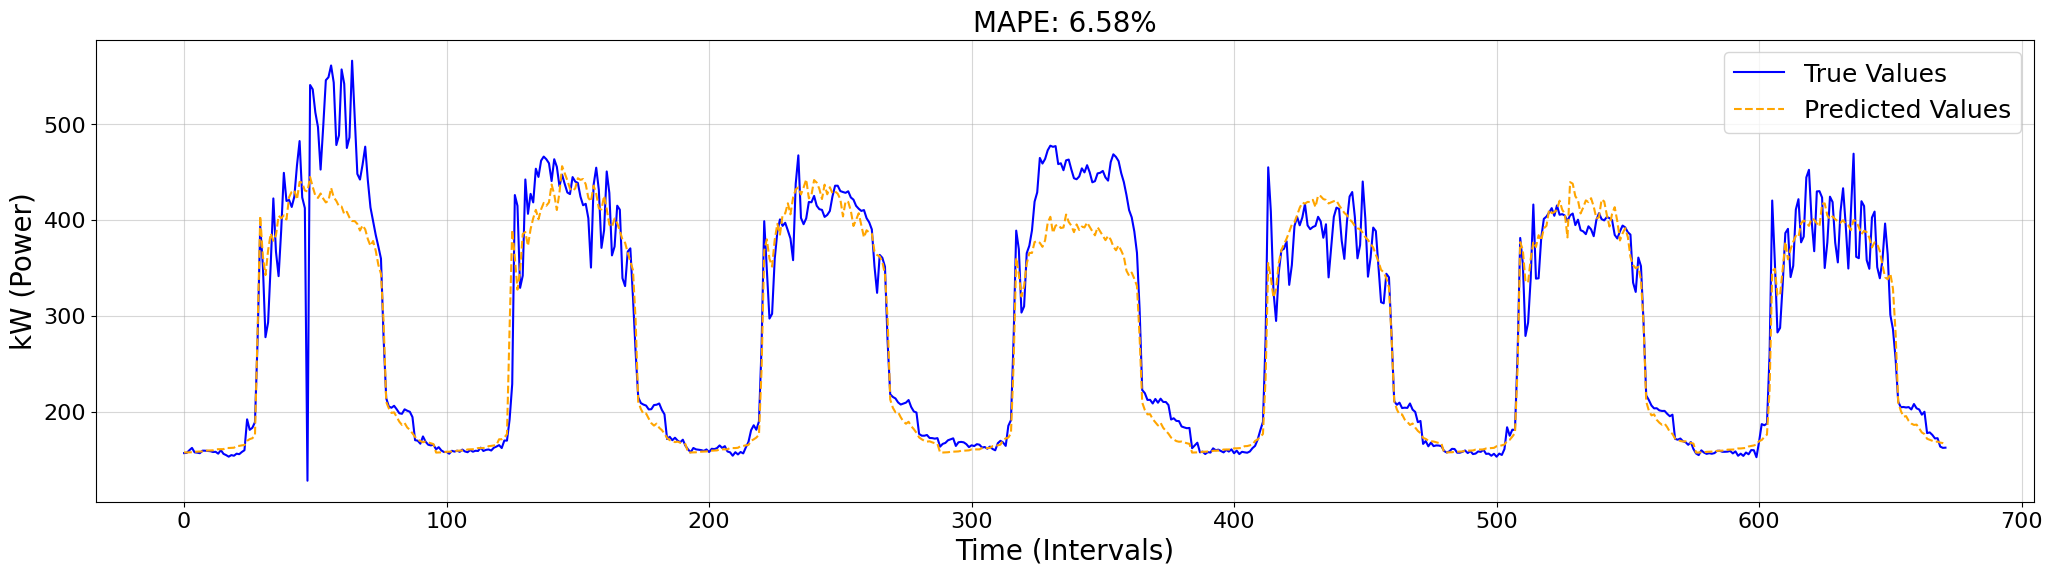

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values = []
    predicted_values = []

    with torch.no_grad():
        for X_enc, X_dec, y in test_loader:  
            output = model(X_enc, X_dec)  

            output = output.view(-1)

            loss = criterion(output, y.view(-1))  
            test_loss += loss.item() * X_enc.size(0)

            true_values.extend(y.cpu().numpy())
            predicted_values.extend(output.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    true_values = np.array(true_values)
    predicted_values = np.array(predicted_values)

    true_values = scaler_y.inverse_transform(true_values.reshape(-1, 1)).flatten()
    predicted_values = scaler_y.inverse_transform(predicted_values.reshape(-1, 1)).flatten()

    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    print(f'MAPE: {mape:.2f}%')

    return true_values, predicted_values, mape

true_values, predicted_values, mape = evaluate_model(model, test_loader, criterion, scaler_y)

plt.figure(figsize=(25, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='orange', linestyle='--')
plt.yticks(fontsize=16)  
plt.xticks(fontsize=16)  
plt.xlabel('Time (Intervals)', fontsize=20)
plt.ylabel('kW (Power)', fontsize=20)
plt.legend(fontsize=18)
plt.title(f'MAPE: {mape:.2f}%', fontsize=20)
plt.grid(alpha=0.5)  
plt.show()
